In [20]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, execute, IBMQ, BasicAer
from qiskit.providers.ibmq import least_busy
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_state_qsphere, plot_histogram
from qiskit.tools.visualization import circuit_drawer 
from qiskit.tools.jupyter import *
from tqdm import tqdm

In [21]:
images = np.load('data/images.npy')

In [22]:
print(images.shape)

(2000, 28, 28)


In [23]:
labels = np.load('data/labels.npy')
print(labels.shape)

(2000,)


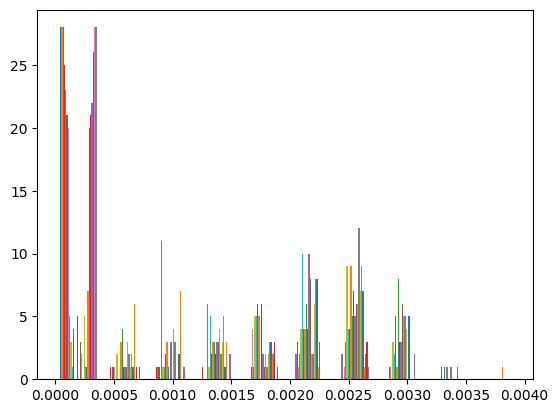

In [24]:
i = np.random.randint(2000)
plt.hist(images[i])
plt.show()

In [25]:
img = np.random.rand(2,2)

In [172]:
def bin_rep(x, n=8):
    t = "{0:b}".format(x)
    if len(t) < n:
        t = '0'*(n-len(t)) + t
    elif len(t) > n:
        t = t[len(t)-n:]
    return t

def encrypt(data):
    data = data * 255 / data.max()
    data = data.astype(int)
    # M, N = data.shape
    # K = 2
    # L = 2
    # MK = M // K
    # NL = N // L
    # data = data[:MK*K, :NL*L].reshape(MK, K, NL, L).max(axis=(1, 3))
    data = data.flatten()
    # assume in 
    # I : 0 - 5
    # X 6 - 10
    # Y 11 - 15
    
    # Step 1 load blank image
    for i in range(6,16):
        qc.h(i)
    
    # Step 2:
    final_output = [] 
    n = 10
    q = 6
    num_qubits = n+q #8 qubits for pixels and 6 qubits for data 
    qc_image = QuantumCircuit(num_qubits, num_qubits) 

    # Create the pixel position qubits, and place them in superposition. 
    # qc_pos = QuantumCircuit(n) 
    for i in range(q):
        qc_image.h(i) 

    for idx in range(q,num_qubits): 
        qc_image.i(idx) 

    # Add the CNOT gates 
    for i , px in enumerate(data): 
        qc_image.x(num_qubits-1) 
        for idx, px_value in enumerate(bin_rep(px, q)): 
            if px_value=='1': 
                qc_image.ccx(num_qubits-1,num_qubits-2, idx) 
        qc_image.x(num_qubits-1) 
        qc_image.barrier() 

    # #run circuit in backend and get the state vector 
    # backend = BasicAer.get_backend('statevector_simulator')
    # result = execute(qc_image, backend=backend).result() 
    # output = result.get_statevector(qc_image) 

    for i in range(num_qubits):
        qc_image.measure(i,i)

    return qc_image
    


In [ ]:
qc_image, sv = encrypt(images[0])
qc_image.draw() 
# circuit_drawer(qc_image, filename='./qc01', output='mpl') 
# circuit_drawer(qc_image, filename='./qc02', output='text')


In [190]:
def decode(hist):
    def bin_rep(x, n=8):
        t = "{0:b}".format(x)
        if len(t) < n:
            t = '0'*(n-len(t)) + t
        elif len(t) > n:
            t = t[len(t)-n:]
        return t
    dp = {}
    for i in range(32):
        for j in range(32):
            dp[bin_rep(i,5) + bin_rep(j,5)] = (i,j) 
    fdp = {}
    for k , v in dp.items():
        for i in range(64):
            fdp[reversed(bin_rep(i, 6) + k)] = v
    img = np.zeros((28,28))
    for i in range(28):
        for j in range(28):
            t = [k for k , v in fdp.items() if v == (i,j)]
            p = -1
            res = None
            for st in t:
                if st in hist:
                    if hist[st] > p:
                        p = hist[st]
                        res = st
            
            img[i][j] = int(res[:6],2) if res else 0
            
    img = img*255/ (img.max() if img.max() != 0 else 1)
    return img

In [173]:
qc = encrypt(images[0])


In [174]:
backend = BasicAer.get_backend('qasm_simulator')
shots = 1_000_000
results = execute(qc, backend=backend, shots=shots).result()
answer = results.get_counts()

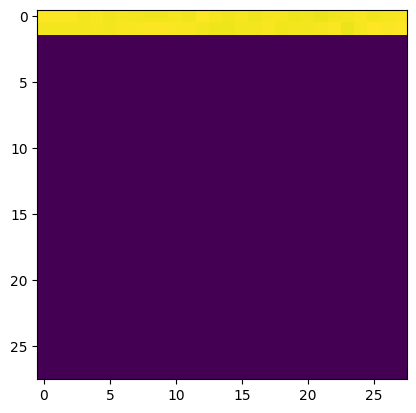

In [191]:
img = decode(answer)
plt.imshow(img)

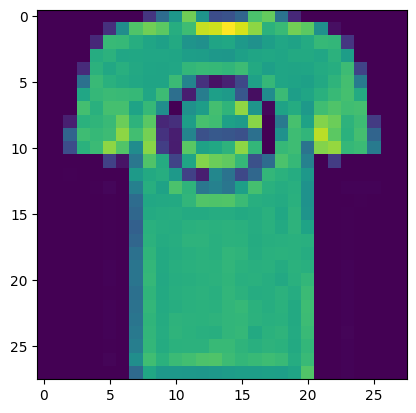

In [111]:
plt.imshow(images[0])